### Import necessary packages

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, MaxPooling2D, Lambda, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### Load dataset

Use CEDAR benchmark as dataset. CEDAR has 2 folders: full_forg and full_org. Each folder contains 1320 signatures (24 signatures for each of 55 writers).

In [2]:
DATA_DIR = './signatures/'
groups_list = next(os.walk(DATA_DIR))[1]
groups_list.sort()

In [3]:
IMG_SHAPE = (155, 220, 1)
H, W, D = IMG_SHAPE
N_WRITERS = 55
N_SIGNATURES_PER_WRITER = 24

In [4]:
writers = []

# Loop through each folder
for group in groups_list:
    image_names = os.listdir(DATA_DIR + group)
    image_names.remove('Thumbs.db')
    
    for i in range(N_WRITERS):
        # Get a batch of size 24, which means a batch that corresponds to a writer's signatures
        writer_signatures = []
        start = N_SIGNATURES_PER_WRITER * i
        end = N_SIGNATURES_PER_WRITER * (i + 1)
        images_per_writer = image_names[start:end]
    
        # For each image in batch
        for image_per_writer in images_per_writer:
            img_path = DATA_DIR + group + '/' + image_per_writer
            img = load_img(img_path, color_mode="grayscale", target_size=(H,W))
            _, img = cv2.threshold(np.array(img), 210, 255, cv2.THRESH_BINARY)
            img = img / 255.
            writer_signatures.append(img)
        
        # Forgery (or genuine) signatures of a writer
        writers.append(writer_signatures)

# Forgery group will be the first 55 elements in writer list, and genuine group is the rest of that one
forg_group = np.array(writers[:N_WRITERS])
orig_group = np.array(writers[N_WRITERS:])

In [5]:
# Take a look at each group shape
print(f'{forg_group.shape}\n{orig_group.shape}')

(55, 24, 155, 220)
(55, 24, 155, 220)


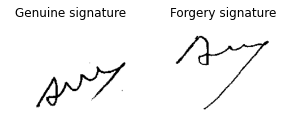

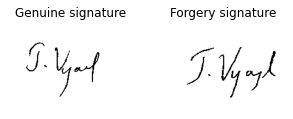

In [6]:
# Visualize the writer's signatures (both forgery and genuine)
def visualize_data(orig, forg):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,5))
    w = np.random.randint(orig.shape[0])
    s = np.random.randint(orig.shape[1])
    ax1.imshow(orig[w][s], cmap='gray')
    ax2.imshow(forg[w][s], cmap='gray')
    ax1.set_title('Genuine signature')
    ax1.axis('off')
    ax2.set_title('Forgery signature')
    ax2.axis('off')

for i in range(2):
    visualize_data(orig_group, forg_group)

### Prepare positive and negative pairs

In [7]:
def make_pairs(orig, forg):
    pair_images = []
    pair_labels = []
    
    for w in range(N_WRITERS):
        
        # ==================== Positive pairs: Genuine-Genuine pairs of a writer ===================== #
        for i in range(N_SIGNATURES_PER_WRITER - 1):
            for j in range(i + 1, N_SIGNATURES_PER_WRITER):
                pair_images.append([orig[w][i], orig[w][j]])
                pair_labels.append([1])
        
        # ==== Negative pairs: NOT take all negative pairs to avoid making the dataset unbalanced ==== #
        
        # Genuine-Forgery pairs of a writer
        for i in range(N_SIGNATURES_PER_WRITER - 5 - 1):
            for j in range(i + 1, N_SIGNATURES_PER_WRITER - 5):
                pair_images.append([orig[w][i], forg[w][j]])
                pair_labels.append([0])
                
        # Genuine signature of a writer and other writer's signature
        for nw in range(w + 1, N_WRITERS):
            for i in range(N_SIGNATURES_PER_WRITER - 21 - 1):
                for j in range(i + 1, N_SIGNATURES_PER_WRITER - 21):           
                    pair_images.append([orig[w][i], orig[nw][j]])
                    pair_labels.append([0])
                    pair_images.append([orig[w][i], forg[nw][j]])
                    pair_labels.append([0])
        
    return np.array(pair_images, dtype=np.float32), np.array(pair_labels, dtype=np.float32)

In [8]:
print("[INFO] preparing positive and negative pairs...")
pair_images, pair_labels = make_pairs(orig_group, forg_group)

[INFO] preparing positive and negative pairs...


In [9]:
print(f'{pair_images.shape}\n{pair_labels.shape}') # 15180 + 9405 + 8910

(33495, 2, 155, 220)
(33495, 1)


In [10]:
# Shuffle image pairs and their corresponding labels to break the correlation between samples
X_shuffled, y_shuffled = shuffle(pair_images, pair_labels, random_state=2)

In [11]:
# The percentages of train, validation, and test are 60%, 20%, and 20% respectively
X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.4, random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2)

### Helper functions

In [12]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))
    
def contrastive_loss(y_true, y_pred, margin=1):
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
    return tf.math.reduce_mean((1 - y_true) * square_pred + y_true * margin_square)

def plot_training(H, plot_path):
    plt.figure()
    plt.plot(H.history['loss'], label='train_loss')
    plt.plot(H.history['val_loss'], label='val_loss')
    plt.plot(H.history['acc'], label='train_acc')
    plt.plot(H.history['val_acc'], label='val_acc')
    plt.title('Training Loss and Accuracy')
    plt.xlabel('Epoch #')
    plt.ylabel('Loss/Accuracy')
    plt.legend(loc='lower left')
    plt.savefig(plot_path)

### Build Siamese Network

In [13]:
def build_siamese_model(input_shape, embedding_dims=128):
    inputs = Input(input_shape)

    conv_layer = Conv2D(64, (3,3), padding='same', activation='relu')(inputs)
    norm_layer = BatchNormalization()(conv_layer)
    pool_layer = MaxPooling2D(pool_size=(2,2))(norm_layer)
    drop_layer = Dropout(0.3)(pool_layer)

    conv_layer = Conv2D(256, (3,3), padding='same', activation='relu')(drop_layer)
    norm_layer = BatchNormalization()(conv_layer)
    pool_layer = MaxPooling2D(pool_size=2)(norm_layer)
    drop_layer = Dropout(0.3)(pool_layer)
    
    global_pool_layer = GlobalAveragePooling2D()(drop_layer)
    outputs = Dense(embedding_dims)(global_pool_layer)
    
    model = Model(inputs, outputs)
    
    return model

In [14]:
# Configure the siamese network
print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
feature_extractor = build_siamese_model(IMG_SHAPE)
print(feature_extractor.summary())
featsA = feature_extractor(imgA)
featsB = feature_extractor(imgB)

[INFO] building siamese network...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 155, 220, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 155, 220, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 155, 220, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 77, 110, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 77, 110, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 110, 256)      147712    
_________________________________________________________________
batch_normalization_1 (Bat

In [15]:
# Construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
output = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=output)

In [16]:
# Compile the model
print("[INFO] compiling model...")
rmsprop = RMSprop(learning_rate=1e-4, momentum=0.9, epsilon=1e-8)
model.compile(loss=contrastive_loss, optimizer=rmsprop, metrics=['acc'])

[INFO] compiling model...


### Train Siamese Network

In [17]:
print("[INFO] training model...")
history = model.fit(
    [X_train[:, 0], X_train[:, 1]], y_train, 
    batch_size=16, 
    epochs=5, 
    validation_data=([X_val[:, 0], X_val[:, 1]], y_val))

[INFO] training model...
Epoch 1/5
1257/1257 [==============================] - 128s 99ms/step - loss: 0.1852 - acc: 0.6813 - val_loss: 0.1412 - val_acc: 0.8574
Epoch 2/5
1257/1257 [==============================] - 124s 98ms/step - loss: 0.1307 - acc: 0.8532 - val_loss: 0.1149 - val_acc: 0.8668
Epoch 3/5
1257/1257 [==============================] - 123s 98ms/step - loss: 0.1060 - acc: 0.8801 - val_loss: 0.0939 - val_acc: 0.8919
Epoch 4/5
1257/1257 [==============================] - 120s 96ms/step - loss: 0.0901 - acc: 0.8961 - val_loss: 0.0825 - val_acc: 0.8994
Epoch 5/5
1257/1257 [==============================] - 119s 94ms/step - loss: 0.0786 - acc: 0.9101 - val_loss: 0.0695 - val_acc: 0.9179


In [18]:
OUTPUT_DIR = './output'
MODEL_PATH = OUTPUT_DIR + '/siamese_model'
PLOT_PATH  = OUTPUT_DIR + '/plot.png'

In [19]:
print("[INFO] saving siamese model...")
model.save(MODEL_PATH)

[INFO] saving siamese model...
INFO:tensorflow:Assets written to: ./output/siamese_model\assets


[INFO] plotting training history...


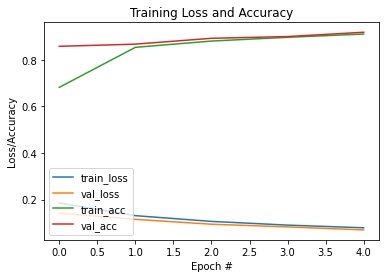

In [20]:
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)

### Evaluate model

In [21]:
def visualize_predictions(pairs, labels, to_show=6, num_col=3, predictions=None):
    num_row = to_show // num_col if to_show // num_col != 0 else 1
    to_show = num_row * num_col

    fig, axes = plt.subplots(num_row, num_col, figsize=(6, 6))
    for i in range(to_show):
        k = np.random.randint(len(pairs))
        ax = axes[i % num_col] if num_row == 1 else axes[i // num_col, i % num_col]
        ax.imshow(tf.concat([pairs[k][0], pairs[k][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        ax.set_title("True: {} | Pred: {:.5f}".format(labels[k][0], predictions[k][0]))
    
    plt.tight_layout(rect=(0, 0, 2, 2), w_pad=5.0)
    plt.show()

In [22]:
results = model.evaluate([X_test[:, 0], X_test[:, 1]], y_test)
print("test_loss, test_acc:", results)

210/210 [==============================] - 12s 48ms/step - loss: 0.0739 - acc: 0.9094
test_loss, test_acc: [0.07385576516389847, 0.9093894362449646]


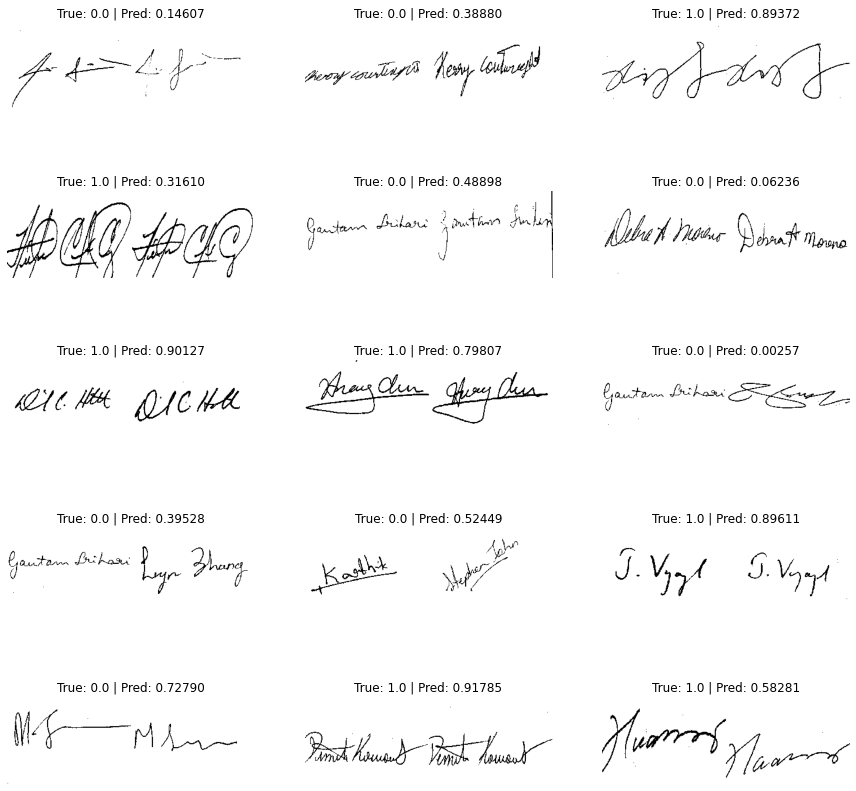

In [23]:
# Predict the label of each sample in test set
preds = model.predict([X_test[:, 0], X_test[:, 1]])
visualize_predictions(X_test, y_test, to_show=15, predictions=preds)